### Data Science Case Study
- Codes to download and  extract the data for "geological_similarity"
- problem link provided in file: 'Data Science Case Study Options 1.0.pdf' 
- Option 2: Geological Image Similarity
- Repository page: https://github.com/shantanuneema/geo_image_problem

#### Prepared by: Shantanu Neema (Cummins Inc.)
#### Chosen name of the tool: GI-Sim

### 1.0 Executive Summary

#### Introduction
This notebook documents and summarizes a tool for identifying interesting patterns in their imagery data for igneous and metamorphic thin sections for 6 types of rocks. The tool has search capability whereby an minerologist will provide an image of interest and will be presented with other K images which are similar to it. The user will have a choice to select how many most similar images are desired.

Data Source: http://aws-proserve-data-science.s3.amazonaws.com/geological_similarity.zip

#### Purpose
The purpose of this work is to improve the efficienty and accuracy of traditionally manual work, which is time consuming and influenced by human errors with implications to affect an oil reservoir's study. A convolutional neural network based method is proposed for thin section analysis to extract information quickly and thus improving efficiency by reducing workload of analyzing rock think section images. 

#### Scope
The functional requirements of this tool (GI-Sim) is to help analyst to find similar images from a labeled image dataset. End user should be able to gain insights from the outputs of the most similar images to the one chosen by them. A machine learning component starts from scrate and load data, restructure it and develop a model for this image similarity application. The model is expected to return the top images that are most similar to the image based on a single image input.

#### Tools

Language : Python 3.6.5 <br>
Packages Used :

1. fastai 1.0.55
2. ipython 7.6.1
3. torch 1.1.0
4. matplotlib 3.1.1
5. split_data_folder* 
6. annoy 1.15.2
7. tqdm 4.32.2
8. torchvision 0.3.0
9. BitVector 3.4.9
10. requests 2.22.0
11. PIL 6.1.0
12. zipfile

Platform : Linux

*modified as needed from - https://github.com/jfilter/split-folders <br>
The library was loaded in the workspace to modify the 'val' folder to make it compactible with fastai library

#### Method

**Convolutional Neural Network** is chosen as preffered choice to develop the model as these microscopic sections have fine granular patterns which might get missed by a regular neural network. It is very important for us to find Spatial and Temporal dependencies in these images to correctly classify them.

Transfer learning is used to develop the current model. It appears that the transfer learning alone can get good results, but for such a fine grain data **transfer learning & fine tuning** is expected to give even better results (reference: https://arxiv.org/abs/1411.1792)

To generate similar images, **LSH** (Locality Sensitive Hashing) technique is used. It refers to a family of functions to hash data points into buckets so that they are located in same bucket with high probablity. This technique makes it easier to identify the thin sections with various degrees of similarity.

#### Deployment

- The user is expected to use this notebook in linux platform to work
- Data will be automatically loaded from the url for the first time user
- The data will be stored and remain available for future runs in the folder path

#### Code Structure

Folders: 
1. geological_similarity - A folder to store and restructure the data 
2. notebooks - A folder to store the notebook(s)
3. src - Source code with developed libraries to support GI-Sim

### 2.0 Notebook setup

#### Enable display
Following 3 lines of code ensure that any edits to the libaries will be reloaded here automatically and all the plots generated by using this notebook will be displayed.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#### Load all important libraries to develop GI-Sim tool

In this step, all the necessary packages are imported. Primary work is accomplished using **fastai** library which sits on **Pytorch**. The fastai library has most of the useful functions needed to create GI-Similarity for building neural network models. 

In [2]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd

from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
from IPython.display import Image
from tqdm import tqdm_notebook

working_folder = str(pathlib.Path.cwd().parent) + '/src/'
os.chdir(working_folder)

import split_data_folder 
import GI_config as conf_lib
import GI_load as load_lib
import GI_lib as lib

np.random.seed(42)

### 3.0 Data Load
In this section step-by-step codes for storing, restructuring and labeling the data are presented
- Data downloaded and stored from the provided aws link and some other parameters like path, ratios etc. see **Appendix A: GI_config.py** 
- Subfolder names shall be used as image labels. For code details refer **Appendix B: split.py** under split_data_folder
- Images are loaded by randomly rotating in both horizontal and vertical directions in addition to normalizing them to adjust the color factors (i.e. brightness, contrast etc.) - refer **Appendix C: GI_load.py**
- Following cell will run GI_main.py where data is loaded from given url followed by split data folder in train (80%), test (10%) and validation (10%) folders with labels as folder names, and showing a sample data to see correct labels
- Test folder is created but not read by fastai, refer section 5.0 (use of data block API https://docs.fast.ai/data_block.html#The-data-block-API)

Data is stored in /home/pr916/notebooks/geo_image_problem
Rearraging data in test, train and valid folders
geological image data loaded
6 classes are:
      ['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']
Train dataset size: 20998 images
Validation dataset size: 4499 images
Given data with labels as shown below:


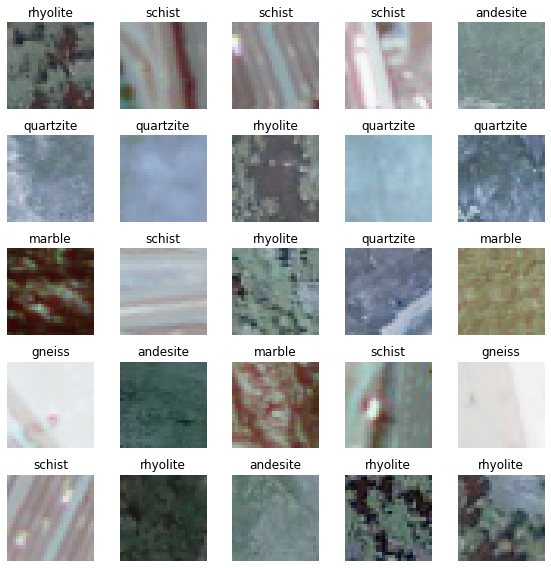

In [3]:
geo_data, tfms = load_lib.load_and_restruct_data(dir_path = conf_lib.dir_path,
                                                 image_folder = conf_lib.image_folder,
                                                 image_size = conf_lib.image_size,
                                                 ratio_train = conf_lib.ratio_train,
                                                 ratio_test = conf_lib.ratio_test,
                                                 ratio_valid = conf_lib.ratio_valid,
                                                 data_folder_list = conf_lib.data_folder_list,
                                                 class_folder_list = conf_lib.class_folder_list,
                                                 aws_url = conf_lib.aws_url,
                                                 seed=42)

print('geological image data loaded')
print('{0} classes are:'.format(geo_data.c))
print('     ', geo_data.classes)
print('Train dataset size: {0}'.format(len(geo_data.train_ds.x)),'images')
print('Validation dataset size: {0}'.format(len(geo_data.valid_ds.x)),'images')

print('Given data with labels as shown below:')
geo_data.show_batch(rows=5, figsize=(8,8))

test_data = (ImageList.from_folder(conf_lib.image_folder)
            .split_by_folder(train='train', valid='test')
            .label_from_folder()
            .transform(tfms)
            .databunch()
            .normalize())

Initial look at the data suggests that images can be rotated and comes in various color combinations which might make it very hard to label by just looking at them. A geologist might have to look for other sources to label these rocks. AI driven image identification model might help them to narrow down the search to see similarities in thin sections to speed up their analysis

### 4.0 Model Development
In this section step-by-step codes for developing and storing a CNN model are presented.

#### Load a CNN model using 80% of the images

- Using the pretrained weights resnet34 model (transfer learning)
reference: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
- To find ideal learning rate in fastai, refer: https://docs.fast.ai/callbacks.lr_finder.html#LRFinder
- Based on paper "Cyclical Learning Rates for Training Neural Networks" by Leslie N. Smith (V6, April 2017). Refer: https://arxiv.org/abs/1506.01186

In [5]:
## Creating the model by chosing resnet18 architecture
arch = models.resnet50
learn = cnn_learner(geo_data, arch, pretrained=True, true_wd=False, metrics=[accuracy, error_rate])

- This initial layers are mostly used for understanding low-level features like curves, lines, shapes, patterns from a large dataset with large number of categories like Imagenet

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 3.02E-02


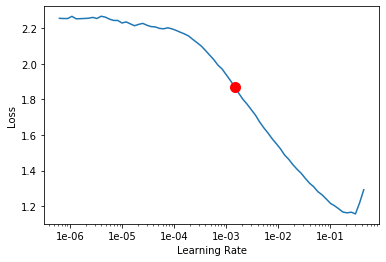

In [6]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad = learn.recorder.min_grad_lr

#### LR Finder indication:
- We choose a value that is approximately in the middle of the sharpest downward slope
- Train the last layer group only in next step (2 epochs) to prevent overfitting at this stage after getting the best suited learning rate as shown above
- Save the model weights 

In [7]:
print('Steepest numerical gradient @lr =', lib.format_decimal(min_grad))
lr = 2e-3
learn.fit_one_cycle(2, lr)
print('saving the model under', conf_lib.image_folder + 'models/')
learn.save('model1-rn50')

Steepest numerical gradient @lr = 1.44e-3


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.198355,0.120103,0.968437,0.031563,02:38
1,0.133252,0.077794,0.983107,0.016893,02:37


saving the model under /home/pr916/notebooks/geo_image_problem/geological_similarity/models/


Since the train_loss > valid_loss, the model suggest underfitting and we shall train it further using the weights from the frozen layer below:

#### Unfreezed the layers, train model and save
- Unfreeze the layers so that all weights from frozen layers can get updated from their pre-trained state
- Use lr_find() again to train the model around best suitable learning rate
- Use thumb rule of range of learning rates from 1/10 of above model and the new suggested learning rate below (reference: fastai course v3 - lesson 2)
- Our aim should be enough train cycles to get train_loss ~ valid_loss to ensure the model is neither underfitting or overfitting. We can make use of fastai's callbacks to find the best model

Note - Though the above model can be directly used to obtain results, fine-tuning it to the provided dataset using fastai will help the model to understand the given dataset better. This process is well known as **Transfer Learning**. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


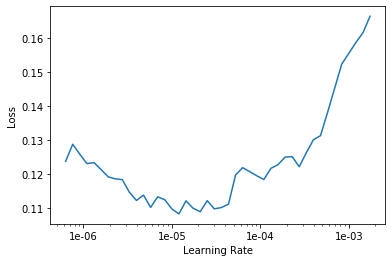

In [8]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [10]:
%%time
learn.fit_one_cycle(10, max_lr=slice(1e-6, lr/10), wd=1e-4, callbacks=[callbacks.SaveModelCallback(learn, 
                                                                                                  every='improvement', 
                                                                                                  monitor='train_loss', 
                                                                                                  name='best')])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.112512,0.081318,0.978884,0.021116,05:48
1,0.105593,0.062747,0.985330,0.014670,05:50
2,0.086827,0.051429,0.987553,0.012447,05:50
3,0.077326,0.046992,0.988442,0.011558,05:50
4,0.066994,0.043188,0.987553,0.012447,05:45
5,0.054770,0.040914,0.989775,0.010224,05:48
6,0.045369,0.036082,0.989553,0.010447,05:47
7,0.048804,0.035169,0.989998,0.010002,05:48
8,0.047920,0.030595,0.991331,0.008669,05:44
9,0.048107,0.030731,0.991776,0.008224,05:46


Better model found at epoch 0 with train_loss value: 0.11251164972782135.
Better model found at epoch 1 with train_loss value: 0.10559282451868057.
Better model found at epoch 2 with train_loss value: 0.08682742714881897.
Better model found at epoch 3 with train_loss value: 0.07732614129781723.
Better model found at epoch 4 with train_loss value: 0.06699404865503311.
Better model found at epoch 5 with train_loss value: 0.05477013438940048.
Better model found at epoch 6 with train_loss value: 0.045368630439043045.
CPU times: user 1d 2h 29min 45s, sys: 3h 26min 9s, total: 1d 5h 55min 55s
Wall time: 58min 10s


#### Trained Model 

Following are few plots from the trained model and saved the model in given path as 'model2-rn50' in same path where data is stored

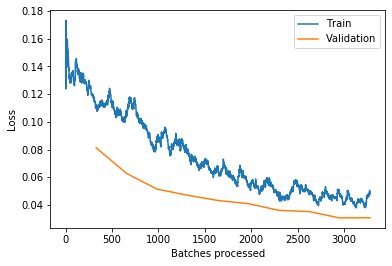

In [12]:
learn.recorder.plot_losses()

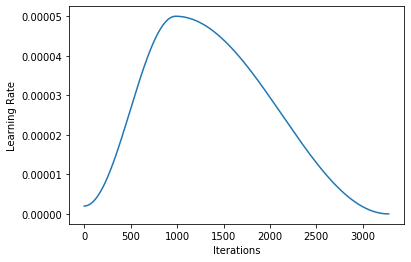

In [13]:
learn.recorder.plot_lr()

In [14]:
print('saving the enhanced model with fine tuning using previous model weights')
learn.save('model2-rn50')

saving the enhanced model with fine tuning using previous model weights


### 5.0 Model Insights

Some insites from the above model are presented below:
- Most confused interpretation (quartzite and andesite have instances with many similar images)
- Test accuracy of the trained model
- Some top differences in predicting images
- model accuracy for train, test and validation sets

In [15]:
learn.interpret().most_confused(min_val=2)

[('quartzite', 'andesite', 23),
 ('andesite', 'rhyolite', 9),
 ('gneiss', 'schist', 9),
 ('andesite', 'quartzite', 2),
 ('rhyolite', 'andesite', 2)]

In [16]:
df_cm = pd.DataFrame(learn.interpret().confusion_matrix(), 
                     index = geo_data.classes,
                     columns = geo_data.classes)

df_cm

,andesite,gneiss,marble,quartzite,rhyolite,schist
andesite,739,0,0,2,9,0
gneiss,0,741,0,0,0,9
marble,0,0,749,0,0,0
quartzite,23,1,0,725,0,1
rhyolite,2,0,0,0,748,0
schist,0,0,0,0,0,750


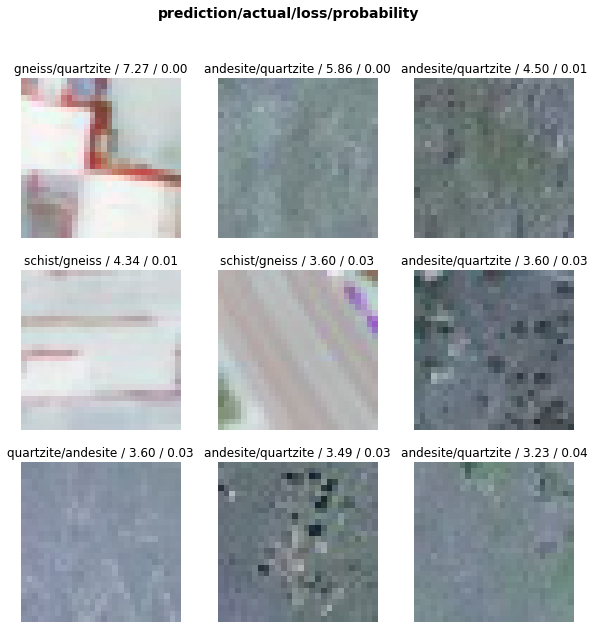

In [17]:
learn.interpret().plot_top_losses(9, figsize=(10,10))

In [18]:
train_accuracy = lib.get_accuracy(learn.validate(learn.data.train_dl))
valid_accuracy = lib.get_accuracy(learn.validate(learn.data.valid_dl))
test_accuracy = lib.get_accuracy(learn.validate(test_data.valid_dl))

print('accuracy for train data: ', train_accuracy, '%', sep='')
print('accuracy for validation data: ', valid_accuracy, '%', sep='')
print('accuracy for test data: ', test_accuracy, '%', sep='')

accuracy for train data: 99.18%
accuracy for validation data: 98.96%
accuracy for test data: 74.92%


### 6.0 Image Similarity 

To get the outputs of an intermediate layer from a model in Pytorch, we make use of a functionality called Hook. Hooks can be used to extract the values of a model from either forward pass or backward pass. Following codes for Pytorch hooks are adapted from fasai library codd. (Refer:https://github.com/fastai/fastai/blob/master/fastai/callbacks/hooks.py)

In [11]:
class Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m:nn.Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hook_func, self.detach, self.stored = hook_func, detach, None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module:nn.Module, input:Tensors, output:Tensors):
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()

#### Loading the model output layer

In following code we shall make a choice on which of the 5 model layer activations to use among Flatten, BatchNorm1d, Dropout, Linear or ReLU to extract from the chosen model. For this dataset, ReLU activation is chosen to learn non-linearity in data. In the deployment notebook, other options are given to the users.

In [22]:
for i in range(1,6):
    print(i, lib.get_named_module_from_model(learn.model, '1.'+str(i)))

1 Flatten()
2 BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
3 Dropout(p=0.25)
4 Linear(in_features=4096, out_features=512, bias=True)
5 ReLU(inplace)


In [126]:
output_layer = lib.get_named_module_from_model(learn.model, '1.3')

#### Image dataframe and Indexing

Following codes will create an image datafram containing all train, valid and test images from the folders to use them as input/output for similarity based on a chosen distance method (cosine or euclidean). The dataframe will have image paths, tensor, and label to identify the image type to be presented in the results. Using the dataframe, an image identifier is shown for indices of which type of images in each respective folder (train, valid and test) to run the show_results function to create desired outputs

In [127]:
train_images = geo_data.train_ds
valid_images = geo_data.valid_ds
test_images = test_data.valid_ds

tvt_images_df = train_images.to_df().append(valid_images.to_df(), sort=False).reset_index(drop=True)
tvt_images_df = tvt_images_df.append(test_images.to_df(), sort=False).reset_index(drop=True)
tvt_images_df.columns = ['image','category']
inference_data_source = (ImageList.from_df(df=tvt_images_df,
                                          path=conf_lib.image_folder,
                                          cols='image').split_none().label_from_df(cols='category'))

inference_data = inference_data_source.transform(tfms, size=conf_lib.image_size).databunch(bs=32).normalize(imagenet_stats)
inference_dataloader = inference_data.train_dl

img_repr_map = {}
with Hook(output_layer, lib.get_output, True, True) as hook:
    for i, (xb,yb) in enumerate(inference_dataloader):
        bs = xb.shape[0]
        img_ids = inference_dataloader.items[i*bs:(i+1)*bs]
        result = learn.model.eval()(xb)
        img_reprs = hook.stored.cpu().numpy()
        img_reprs = img_reprs.reshape(bs, -1)
        for img_id, img_repr in zip(img_ids, img_reprs):
            img_repr_map[img_id] = img_repr

img_repr_df = pd.DataFrame(img_repr_map.items(), columns=['img_id', 'img_repr'])
img_repr_df['label'] = [inference_data.classes[x] for x in inference_data.train_ds.y.items[0:img_repr_df.shape[0]]]
img_repr_df['label_id'] = inference_data.train_ds.y.items[0:img_repr_df.shape[0]]

In [128]:
train_df = img_repr_df[img_repr_df['img_id'].str.contains('train')]
valid_df = img_repr_df[img_repr_df['img_id'].str.contains('valid')]
test_df = img_repr_df[img_repr_df['img_id'].str.contains('test')]

train_ids = []; valid_ids = []; test_ids = []
for i in range(6):
    train_ids.append(train_df[train_df['label'] == geo_data.classes[i]].index[0])
    valid_ids.append(valid_df[valid_df['label'] == geo_data.classes[i]].index[0])
    test_ids.append(test_df[test_df['label'] == geo_data.classes[i]].index[0])
print('Indexes in order of ', [geo_data.classes[i] for i in range(6)])
print('first indexes of each class type:', train_ids)
print('first indexes of each class type:', valid_ids)
print('first indexes of each class type:', test_ids)

Indexes in order of  ['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']
first indexes of each class type: [0, 3500, 7000, 10498, 13998, 17498]
first indexes of each class type: [20998, 21748, 22498, 23247, 23997, 24747]
first indexes of each class type: [25497, 26247, 26997, 27748, 28498, 29248]


### 7.0 Results

Following function will take input like **image index** (see above) and **k** (desired amount of top similar images) from the user to plot them

In [129]:
def show_results(ind, k):
    image_id = ind
    base_image, base_label, similar_images_df = lib.get_similar_images_annoy(image_id, img_repr_df, inference_data, k)
    image_path = img_repr_df.iloc[image_id, [0,1,2]].img_id
    print(base_label)
    print(base_image)
    display(Image(filename=image_path, width=256, height=256))
    print('Images similar to above based on', conf_lib.sim_dist_type, 'distance: ')
    lib.show_similar_images(similar_images_df, learn)

marble
/home/pr916/notebooks/geo_image_problem/geological_similarity/valid/marble/0XBJT.jpg


Images similar to above based on angular distance: 


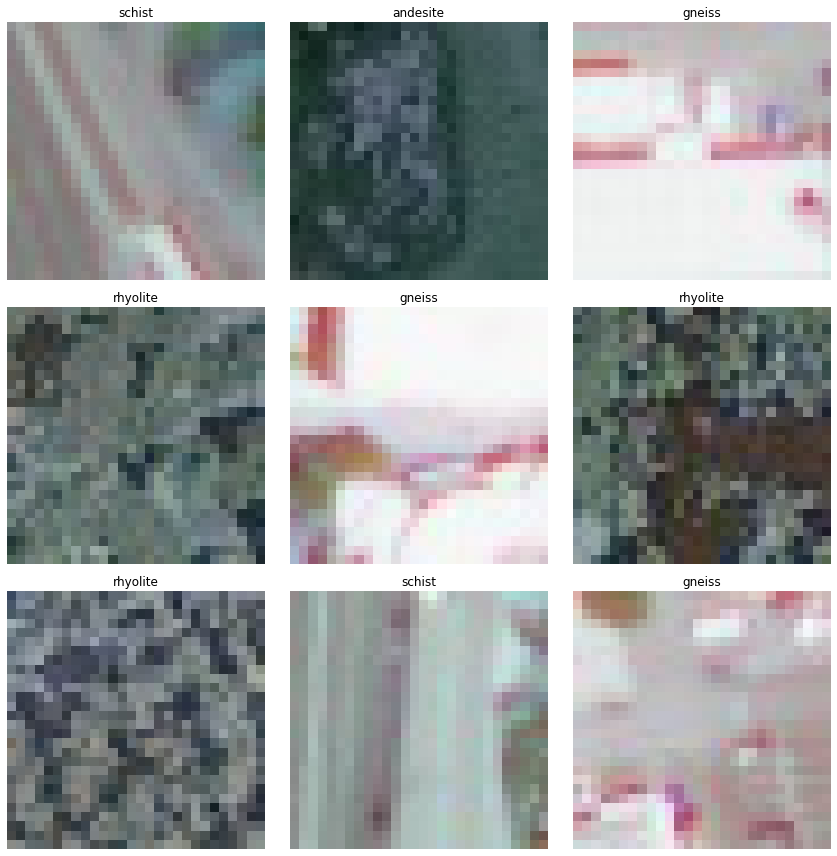

In [130]:
show_results(22500, 9) # Marble thin section from validation folder

quartzite
/home/pr916/notebooks/geo_image_problem/geological_similarity/test/quartzite/EQ5BX.jpg


Images similar to above based on angular distance: 


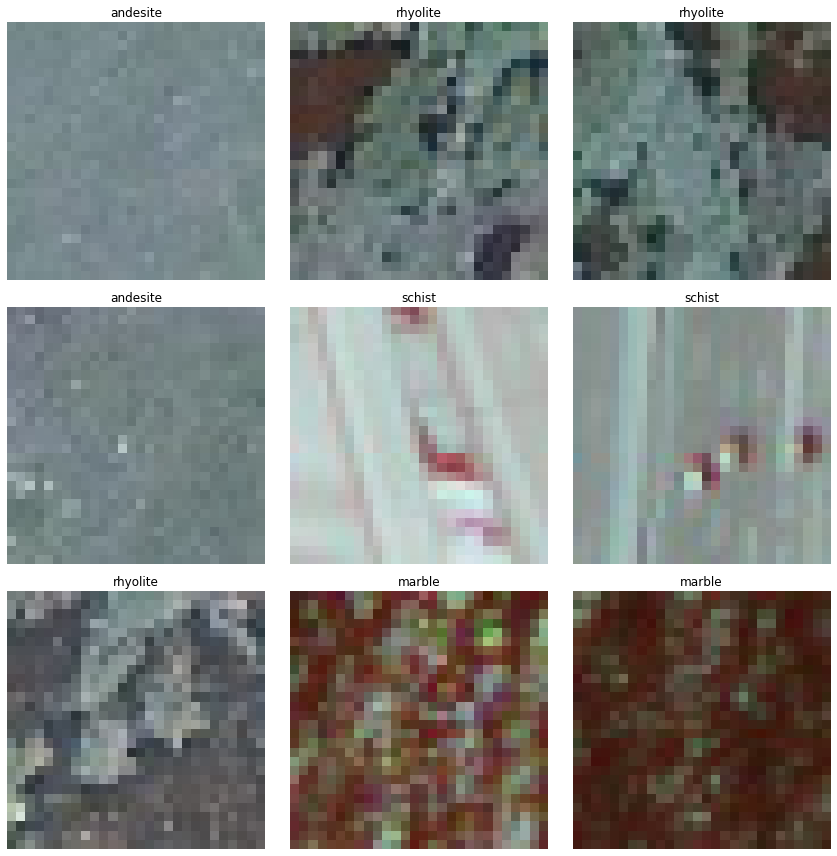

In [120]:
show_results(27750, 9) # Quartize from test image folder

gneiss
/home/pr916/notebooks/geo_image_problem/geological_similarity/train/gneiss/9VDK2.jpg


Images similar to above based on angular distance: 


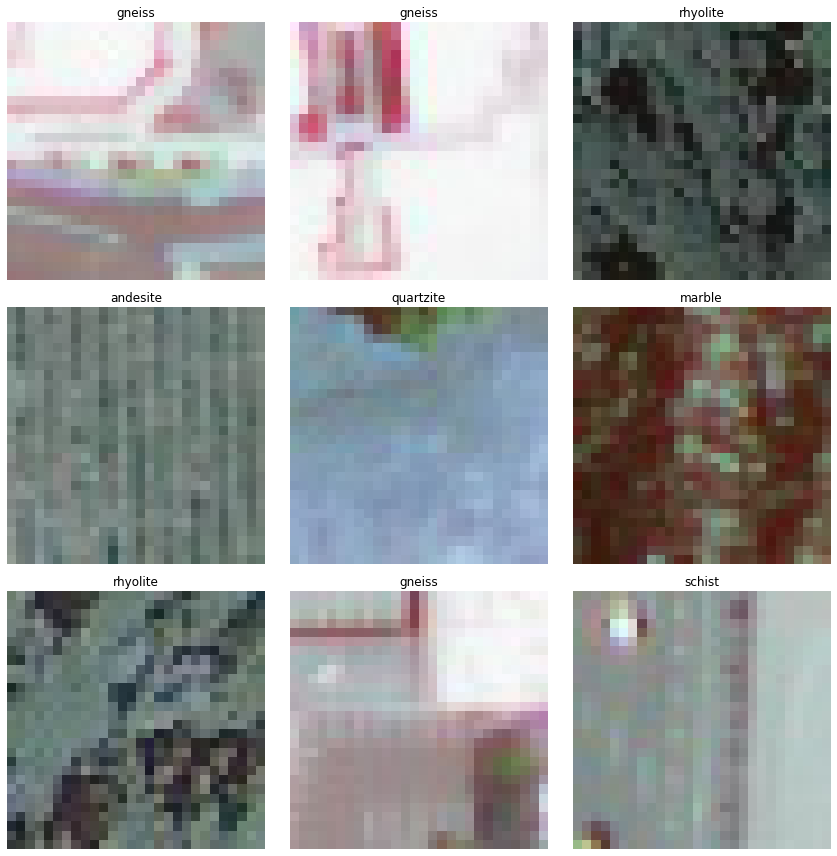

In [121]:
show_results(3500, 9) # Gneiss from train folder

andesite
/home/pr916/notebooks/geo_image_problem/geological_similarity/valid/andesite/0UHNC.jpg


Images similar to above based on angular distance: 


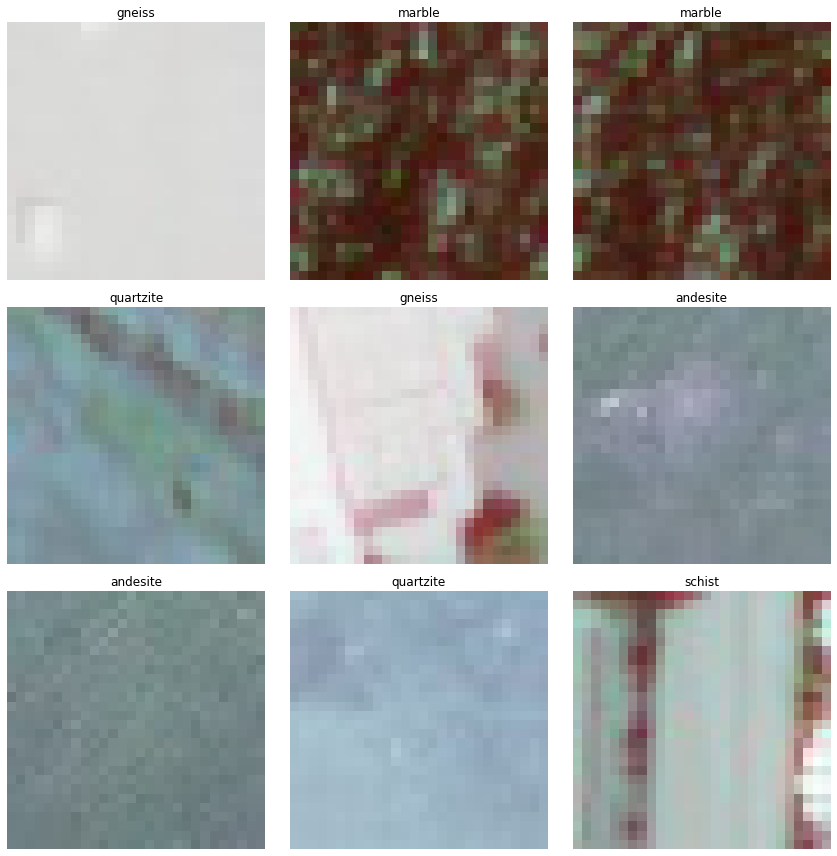

In [122]:
show_results(21000, 9) # Andesite from validation folder

rhyolite
/home/pr916/notebooks/geo_image_problem/geological_similarity/train/rhyolite/ZA8KK.jpg


Images similar to above based on angular distance: 


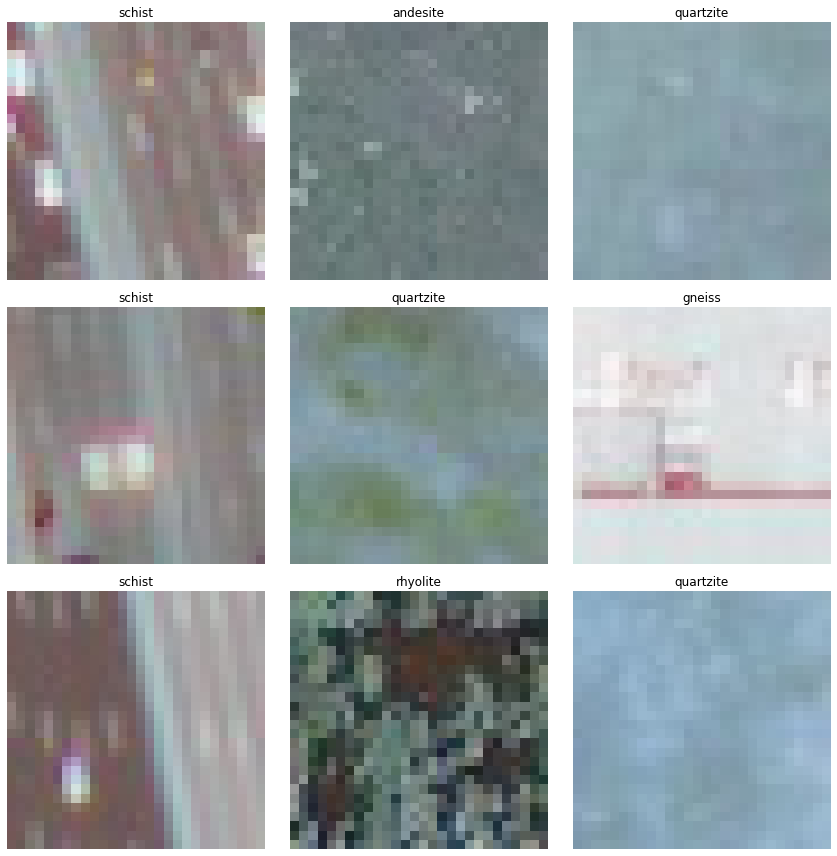

In [123]:
show_results(14000, 9) # Rhyolite from train folder 

schist
/home/pr916/notebooks/geo_image_problem/geological_similarity/test/schist/ER5GK.jpg


Images similar to above based on angular distance: 


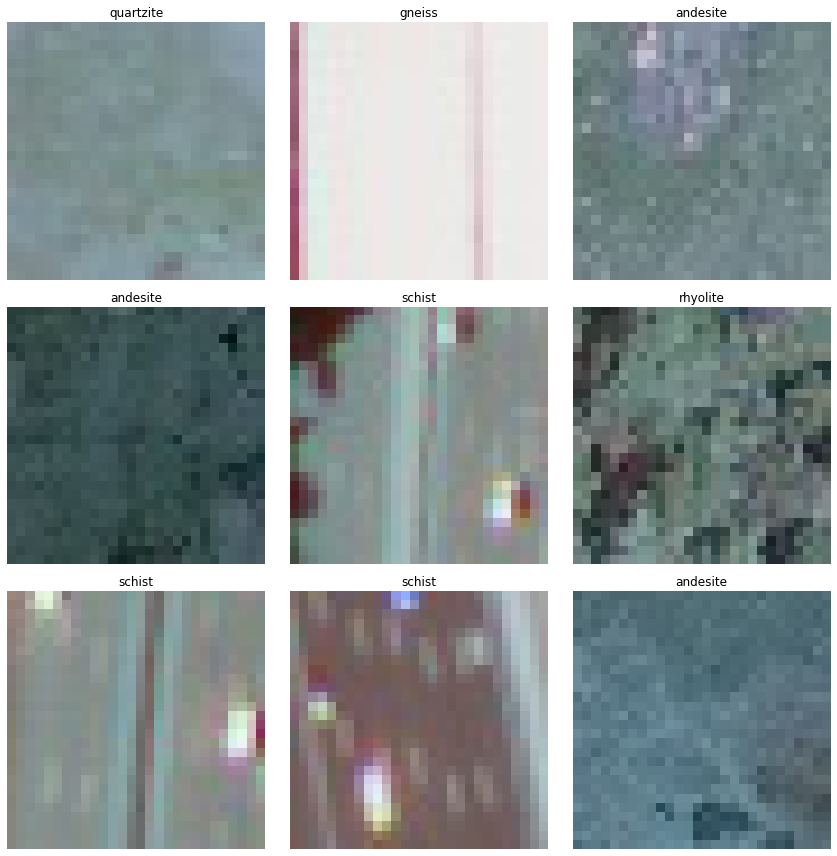

In [124]:
show_results(29250, 9) # Schist from test folder

### 8.0 Conclusion

Based on above results, it is clear that image similarity does not mean that the algorithm will result in either similar rock label or similar color. It appears that the similarity using either cosine of euclidean distance here means that the model is trying to find similar pattern in microscopic thin sections and not particularly looking for same rock or same color

### References:

1. Practical deep learning for coders, v3 (fastai) - https://github.com/fastai/course-v3 (Jan 2018 - June 2018 Lecture Series)
2. Appalaraju S., Chaoji V., "Image Similarity using Deep CNN and Curriculum Learning", Amazon Development Center (India) Pvt. Ltd., Sept 2017
3. Wang J., Song Y., Leung T., Rosenberg C., Philbin J., Chen B., Wu Y., "Learning Fine-grained Image Similarity with Deep Ranking", Northwestern University, Google Inc., California Institute of Technology, April 2014
4. Laarhoven T., "L2 Regularization versus Batch and Weight Normalization", Radbound University, June 2017
5. Deep learning explorations on image similarity using Locality Sensitive Hashing - https://github.com/aayushmnit/Deep_learning_explorations/tree/master/8_Image_similarity_search
6. Cheng G., Guo W., "Rock images classification by using deep convolution neural network", Journal of Physics Conference Series, August 2017 
7. Similarity Queries using Annoy (Tutorial) - https://github.com/spotify/annoy 
8. Similar Images Recommendations using FastAi and Annoy - https://jvn.io/gautham20/e6bd87b3597e4a12bb601216b4d2289d

#### Appendix A: GI_config.py

#### Appendix B: split.py

#### Appendix C: GI_load.py

### Appendix D: GI_lib.py